## DATA 620 - Project 1

---

### Mael Illien, Jeremy OBrien & Vanita Thompson

* Identify a large 2-node network dataset—you can start with a dataset in a repository. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
* Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
* What can you infer about each of the distinct groups?

You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Sunday.

## Introduction

## Setup

In [1]:
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display, HTML
%matplotlib inline

## Data Import

In [2]:
# ISS data example - likely too few nodes for assignment

#iss_data = pd.read_csv('IS_ALLEGIANCES_2M.csv')
#iss_data.info()

In [46]:
# digg dataset test
digg_data = pd.read_csv('digg.edges')
#digg_data.sort_values(by='1214799565', ascending=False).head(n=20)

In [4]:
len(digg_data)

4749849

In [47]:
# rename columns
digg_data.columns = ['user_id','story_id','timestamp']

In [6]:
digg_data.head()

,user_id,story_id,timestamp
0,1,3,1230047012
1,1,4,1194104160
2,1,5,1199180573
3,1,6,1196465462
4,7,8,1195676634


Looking at unique values:

In [7]:
len(set(digg_data['timestamp']))

3297589

In [8]:
# Unique users
len(set(digg_data['user_id']))

166632

In [9]:
# Unique story ratings (ratings not available)
len(set(digg_data['story_id']))

261770

In [50]:
unique_users = set(digg_data['user_id']) # Identify unique users
downsample_n = 50 # Set source node sample 
random.seed(620)
digg_subset = digg_data[digg_data['user_id'].isin(random.sample(unique_users, downsample_n))]
digg_subset

,user_id,story_id,timestamp
34168,18483,18484,1245334537
34169,18483,18485,1140978151
75273,32614,32615,1202372915
166311,58089,58090,1149360216
166312,58089,58091,1202500506
...,...,...,...
4714438,10996,283130,1243965368
4735481,10996,283159,1243989233
4738935,29474,283163,1243966491
4747954,12655,283181,1245095604


In [56]:
import networkx as nx

In [52]:
df = digg_subset
zipped = list(zip(df['user_id'],df['story_id']))

users = list(set(df['user_id']))
stories = list(set(df['story_id']))

B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(stories, bipartite=1)
B.add_edges_from(zipped)

{38274: Text(-0.06485968083143234, -0.012313304468989372, '38274'),
 113928: Text(0.20967988669872284, 0.15221582353115082, '113928'),
 122890: Text(-0.2092655450105667, 0.07495519518852234, '122890'),
 4107: Text(0.06023681163787842, -0.04752518609166145, '4107'),
 125835: Text(-0.2957530617713928, -0.09022952616214752, '125835'),
 126474: Text(-0.27515700459480286, -0.07754821330308914, '126474'),
 134171: Text(-0.18596354126930237, -0.8432214260101318, '134171'),
 62492: Text(0.537845253944397, -0.6136274337768555, '62492'),
 6304: Text(0.062081873416900635, -0.07977955788373947, '6304'),
 29474: Text(0.11448211222887039, 0.0557413175702095, '29474'),
 100258: Text(-0.22923679649829865, 0.11612711101770401, '100258'),
 127400: Text(-0.27117037773132324, -0.09151085466146469, '127400'),
 131882: Text(-0.04065326973795891, -0.8999369144439697, '131882'),
 82221: Text(0.4050562083721161, -0.7841456532478333, '82221'),
 4526: Text(-0.0954909473657608, 0.10401000827550888, '4526'),
 3832

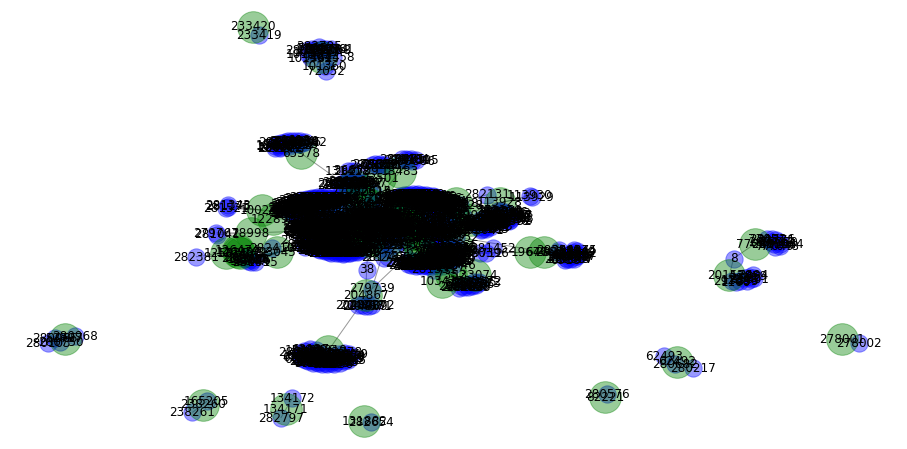

In [54]:
plt.rcParams["figure.figsize"] = (16,8)
plt.axis('off')
pos=nx.spring_layout(B)


{38274: Text(-0.06485968083143234, -0.012313304468989372, '38274'),
 113928: Text(0.20967988669872284, 0.15221582353115082, '113928'),
 122890: Text(-0.2092655450105667, 0.07495519518852234, '122890'),
 4107: Text(0.06023681163787842, -0.04752518609166145, '4107'),
 125835: Text(-0.2957530617713928, -0.09022952616214752, '125835'),
 126474: Text(-0.27515700459480286, -0.07754821330308914, '126474'),
 134171: Text(-0.18596354126930237, -0.8432214260101318, '134171'),
 62492: Text(0.537845253944397, -0.6136274337768555, '62492'),
 6304: Text(0.062081873416900635, -0.07977955788373947, '6304'),
 29474: Text(0.11448211222887039, 0.0557413175702095, '29474'),
 100258: Text(-0.22923679649829865, 0.11612711101770401, '100258'),
 127400: Text(-0.27117037773132324, -0.09151085466146469, '127400'),
 131882: Text(-0.04065326973795891, -0.8999369144439697, '131882'),
 82221: Text(0.4050562083721161, -0.7841456532478333, '82221'),
 4526: Text(-0.0954909473657608, 0.10401000827550888, '4526'),
 3832

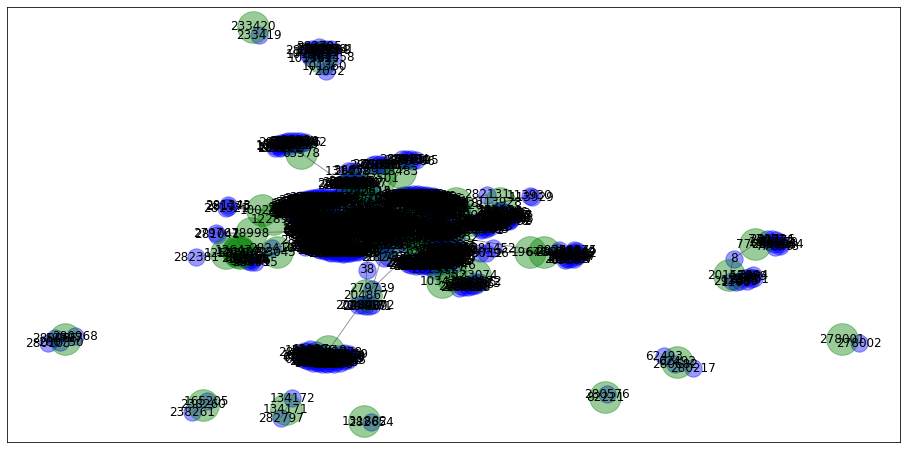

In [55]:
nx.draw_networkx_nodes(B, pos, nodelist=stories, node_color='blue', alpha = 0.4)
nx.draw_networkx_nodes(B, pos, nodelist=users, node_color='green', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(B, pos, alpha = 0.4)
nx.draw_networkx_labels(B, pos)

In [34]:
stories, users = nx.bipartite.sets(g)
plt.rcParams["figure.figsize"] = (16,8)
plt.axis('off')
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=stories, node_color='blue', alpha = 0.4)
nx.draw_networkx_nodes(g, pos, nodelist=users, node_color='green', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(g, pos, alpha = 0.4)
nx.draw_networkx_labels(g, pos);

AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.

## Data Processing